# Product Studio Final Project

## Predicting Housing Prices in Cordoba State - Argentina

### Authors: 
- __Rachel Ward__ <br>
- __Julian Ruggiero__

## Data Dictionary
For our first data source we take properties listing located at https://www.properati.com.ar/data/. Properati Data is the data division of Properati, the Latin American real estate search site.

On this page we can find links to different tools and data sets to use them freely in this project. We will be using properties published in Argentina under [this](https://storage.googleapis.com/properati-data-public/ar_properties.csv.gz) dataset.

## Exploratory Data Analysis

In [3]:
import pandas as pd

# getting data
df = pd.read_csv('ar_properties.csv')

In [4]:
# checking columns
df.columns

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'currency', 'price_period',
       'title', 'description', 'property_type', 'operation_type'],
      dtype='object')

In [5]:
df.operation_type.value_counts()

Venta                776883
Alquiler             191278
Alquiler temporal     31839
Name: operation_type, dtype: int64

In [6]:
# getting only records from Cordoba State and for Sale
df = df[(df.l2 == 'Córdoba') & (df.operation_type == 'Venta')]
df.shape

(49307, 25)

In [7]:
# sanity check
pd.set_option('display.max_columns', None)
df.reset_index(inplace=True)
df.head(2)

,index,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,l5,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
0,9,a6/+5gA0rftdR7oO+ZP5Og==,Propiedad,2019-11-17,2020-01-07,2019-11-17,-31.084896,-64.309776,Argentina,Córdoba,Villa Cerro Azul,NaN,NaN,NaN,NaN,NaN,NaN,430.0,NaN,NaN,NaN,NaN,Lima 100 - U$D 2.500 - Terreno en Venta,Terreno virgen en esquina sobre la avenida Lim...,Lote,Venta
1,25,pCrMwMkWbvkPDcx8zppfoQ==,Propiedad,2019-11-17,2020-02-07,2019-11-17,-31.411503,-64.164228,Argentina,Córdoba,Córdoba,NaN,NaN,NaN,2.0,1.0,1.0,57.0,45.0,NaN,NaN,NaN,DEPTO 1 DORMITORIO CON BALCON GENERAL PAZ CORDOBA,Corredor Responsable: Juan Manuel Quiroga - CP...,Departamento,Venta


In [8]:
# checking ad_type values
df.ad_type.value_counts()

Propiedad    49307
Name: ad_type, dtype: int64

In [9]:
# checking ad_type values
df.price_period.value_counts()

Mensual    11312
Name: price_period, dtype: int64

The following columns can be excluded:
- id: it does not add any value for a ML model.
- ad_type: it has only one unique value.
- start_date and end_date: we will consider only the created_on date to get the appropriate currency value if it applies.
- lat and lon: not needed for ML purposes.
- l1: refers to the country, we only working with Argentina.
- l2: refers to the state, we only working with 'Cordoba' state.
- l5: has all null values.
- l6: has all null values.
- price_period: has only one value.
- title: not needed for ML purposes.
- description: not needed for ML purposes.

In [10]:
# renaming
df.rename(columns={'l3': 'city', 'l4': 'neighborhood'},
         inplace=True)

# selecting columns
columns = ['created_on', 'city', 'neighborhood', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 
          'price', 'currency', 'property_type']

In [11]:
# sanity check
df = df[columns]
df.head(2)

,created_on,city,neighborhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,property_type
0,2019-11-17,Villa Cerro Azul,NaN,NaN,NaN,NaN,430.0,NaN,NaN,NaN,Lote
1,2019-11-17,Córdoba,NaN,2.0,1.0,1.0,57.0,45.0,NaN,NaN,Departamento


In [12]:
# chequing data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49307 entries, 0 to 49306
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   created_on       49307 non-null  object 
 1   city             37758 non-null  object 
 2   neighborhood     6212 non-null   object 
 3   rooms            18774 non-null  float64
 4   bedrooms         11411 non-null  float64
 5   bathrooms        33012 non-null  float64
 6   surface_total    9817 non-null   float64
 7   surface_covered  16448 non-null  float64
 8   price            47380 non-null  float64
 9   currency         47324 non-null  object 
 10  property_type    49307 non-null  object 
dtypes: float64(6), object(5)
memory usage: 4.1+ MB


Despite we have latitude and longitude, we were not able to get neighborhood name, as it has a very particular naming based on Cordoba region. We tried several API services and results were not that accurate, so we rather work with the records that have a valid value in neighborhood.

In [13]:
df = df[(df.city.notna()) & (df.neighborhood.notna()) & (df.currency.notna()) & (df.price.notna())]
df.shape

(5831, 11)

We saw that __property_type__ values are in Spanish, we will translate them to English.

In [14]:
df.property_type.value_counts()

Departamento       4555
Oficina             376
Casa                275
Cochera             188
Lote                154
Local comercial     133
Otro                 73
PH                   72
Casa de campo         3
Depósito              2
Name: property_type, dtype: int64

In [15]:
# translating values
df.property_type.replace({'Otro': 'other', 
                          'Casa': 'house',
                          'Departamento': 'apartment',
                          'Lote': 'land',
                          'PH': 'horizontal_property',
                          'Oficina': 'office',
                          'Local comercial': 'store',
                          'Cochera': 'garage',
                          'Casa de campo': 'farm_house',
                          'Depósito': 'warehouse'}, inplace=True)

# sanity check
df.property_type.value_counts()

apartment              4555
office                  376
house                   275
garage                  188
land                    154
store                   133
other                    73
horizontal_property      72
farm_house                3
warehouse                 2
Name: property_type, dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5831 entries, 6 to 49064
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   created_on       5831 non-null   object 
 1   city             5831 non-null   object 
 2   neighborhood     5831 non-null   object 
 3   rooms            4609 non-null   float64
 4   bedrooms         1943 non-null   float64
 5   bathrooms        5118 non-null   float64
 6   surface_total    1371 non-null   float64
 7   surface_covered  3731 non-null   float64
 8   price            5831 non-null   float64
 9   currency         5831 non-null   object 
 10  property_type    5831 non-null   object 
dtypes: float64(6), object(5)
memory usage: 546.7+ KB


Chequing missing values

In [17]:
null_count = df.isnull().sum()

# get percent of missing data
missing = df.isnull().mean() * 100

#creating a dictionary with the count of null and negative values
d = {'# Missing':null_count,'% of Total':missing}
pd.DataFrame(d)

,# Missing,% of Total
created_on,0,0.000000
city,0,0.000000
neighborhood,0,0.000000
rooms,1222,20.956954
bedrooms,3888,66.678100
bathrooms,713,12.227748
surface_total,4460,76.487738
surface_covered,2100,36.014406
price,0,0.000000
currency,0,0.000000


We see a high number of missing values for several fields. We consider these columns to be potential good predictors, so we won't delete them, but impute the missing values using KNN imputer from Sklearn.

### Unify currency

In [18]:
# checking currency values
df.currency.value_counts()

USD    5590
ARS     241
Name: currency, dtype: int64

We need to unify currencies, and as the majority of the properties are in USD, then we will convert everything to USD. For this, we will get the corresponding ARS value in the date the property was posted and transform the price to the appropriate USD value.

In [19]:
# getting dates to get convertion rates
currency_dates = df[df.currency == 'ARS'].created_on.unique()
len(currency_dates)

97

In [20]:
import requests
currency = {}
for date in currency_dates:
    if date not in currency.keys():
        response = requests.get('http://api.currencylayer.com/historical?access_key=ab17a2ddeb50e743484559f30bd83a13&date='+date)
        key = response.json()['date']
        value = response.json()['quotes']['USDARS']
        currency[key] = value

In [21]:
# convert dictionary to dataframe and export as csv
df_currency = pd.DataFrame(currency.items(),
                          columns=['created_on', 'ARS_to_USD'])
df_currency.sort_values(by=['created_on']).to_csv('currency_conversion.csv', index=False)

Update the __price__ value for those records that have ARS as __currency__

In [22]:
# before updating
df[df.currency=='ARS'].head(2)

,created_on,city,neighborhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,property_type
37,2020-08-01,Córdoba,Nueva Córdoba,3.0,2.0,1.0,NaN,NaN,7500000.0,ARS,apartment
445,2020-06-01,Córdoba,Nueva Córdoba,NaN,NaN,NaN,NaN,NaN,1550000.0,ARS,garage


In [23]:
def get_dollar_rate(current_currency, date, price):
    if current_currency == 'ARS':
        return price/currency[date] #currency is a dictionary with the date as key and conversion rate as the value
    else:
        return price
df['price'] = df.apply(lambda x: get_dollar_rate(x['currency'], x['created_on'], x['price']), axis=1)

In [24]:
# after updating
df[df.currency=='ARS'].head(2)

,created_on,city,neighborhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,property_type
37,2020-08-01,Córdoba,Nueva Córdoba,3.0,2.0,1.0,NaN,NaN,103624.932789,ARS,apartment
445,2020-06-01,Córdoba,Nueva Córdoba,NaN,NaN,NaN,NaN,NaN,22600.791144,ARS,garage


We can now drop currency column, as it is all USD.

In [25]:
# excluding from dataframe
df = df.drop('currency', axis=1)

### Getting Year, Month and Day from Date

In [26]:
df['created_on'] = pd.to_datetime(df['created_on'], errors='coerce')

df['created_on_year'] = df['created_on'].dt.year
df['created_on_month'] = df['created_on'].dt.month
df['created_on_day'] = df['created_on'].dt.day

# excluding from dataframe
df = df.drop('created_on', axis=1)

### Response Variable

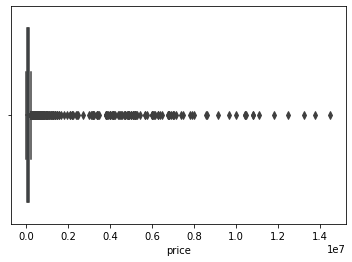

In [28]:
# Rating
import seaborn as sns
sns.boxplot(x="price", data = df);

In [36]:
df[df.price>3000000]

,city,neighborhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,created_on_year,created_on_month,created_on_day
307,Córdoba,Alta Córdoba,1.0,NaN,NaN,NaN,42.0,4860000.0,apartment,2020,5,9
339,Córdoba,Centro,NaN,NaN,NaN,NaN,NaN,3200000.0,garage,2019,9,19
5556,Córdoba,General Paz,1.0,NaN,NaN,NaN,1.0,6035000.0,apartment,2020,6,18
6610,Córdoba,Nueva Córdoba,2.0,NaN,2.0,NaN,67.0,10800000.0,apartment,2020,7,9
7679,Córdoba,Nueva Córdoba,1.0,NaN,1.0,NaN,NaN,6750000.0,apartment,2020,9,10
...,...,...,...,...,...,...,...,...,...,...,...,...
43478,Córdoba,Nueva Córdoba,2.0,NaN,2.0,NaN,118.0,14500000.0,apartment,2020,2,25
43483,Córdoba,Centro,1.0,NaN,2.0,NaN,NaN,4600000.0,apartment,2020,2,25
43526,Córdoba,Nueva Córdoba,2.0,NaN,2.0,NaN,73.0,5460000.0,apartment,2020,2,25
46431,Córdoba,Nueva Córdoba,1.0,NaN,1.0,NaN,50.0,3800000.0,apartment,2020,4,3


In [32]:
# summary stats
df.price.describe()

count    5.831000e+03
mean     2.267324e+05
std      8.558134e+05
min      3.933770e+03
25%      6.000000e+04
50%      8.300000e+04
75%      1.350000e+05
max      1.450000e+07
Name: price, dtype: float64

### Numeric Features

In [37]:
import matplotlib.pyplot as plt 
import seaborn as sns
numeric = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']

In [38]:
df[numeric].describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered
count,4609.000000,1943.00000,5118.000000,1371.000000,3731.000000
mean,2.117162,1.54246,1.397616,95.643326,90.448405
std,1.344899,0.97027,0.833612,290.510488,186.232269
min,1.000000,0.00000,1.000000,11.000000,-1.000000
25%,1.000000,1.00000,1.000000,46.000000,43.000000
50%,2.000000,1.00000,1.000000,58.000000,54.000000
75%,3.000000,2.00000,2.000000,86.000000,80.000000
max,22.000000,17.00000,16.000000,10000.000000,4500.000000


In [39]:
df[(df.bedrooms > 15) | (df.bathrooms > 10)]

,city,neighborhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,created_on_year,created_on_month,created_on_day
7699,Córdoba,Centro,1.0,0.0,16.0,NaN,NaN,1685800.0,office,2020,9,10
7706,Córdoba,Centro,1.0,0.0,13.0,NaN,NaN,1556000.0,office,2020,9,10
34068,Córdoba,Alberdi,NaN,17.0,14.0,NaN,48.0,420000.0,store,2020,8,10


We might want to exclude these records, it seems to much bedrooms and bathrooms for an office or a store.

In [40]:
df = df[(df.bedrooms < 15) | (df.bathrooms < 10)]

Next we plot the numeric explanatory features vs the reponse.

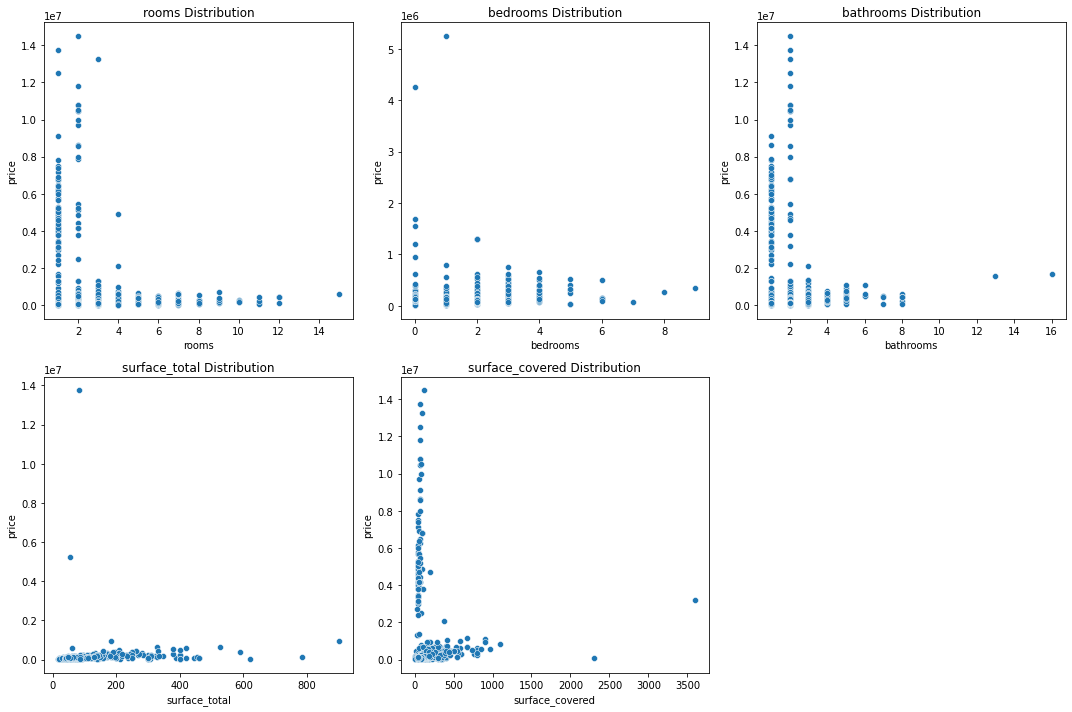

In [42]:
#define a figure to which we will add histogram of each attribute.
plt.figure(figsize=(15,10))

#use an index to identify the spot of the subplot
j = 1

# Columns
for k in numeric: #for each numeric column in the dataframe        
    plt.subplot(2,3,j)
    sns.scatterplot(x=k, y = "price", data = df)
    plt.title(k + " Distribution");
    j = j + 1 #add 1 to go to the next subplot space

#show results
plt.tight_layout()
plt.show();

### Create Dummy Columns

In [ ]:
dummies = ['city', 'neighborhood']
df_dummies = pd.get_dummies(df, columns = dummies, drop_first=True)